## 策略逻辑：
60分钟看长短期MA趋势， 15分钟做均线择时。

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 33; slowPeriod = 55
    signalMaPeriod = 20
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod', 'slowPeriod',
                 'signalMaPeriod'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        pass
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
#                 self.cancelAll() # 撤销挂单
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做交易信息记录的策略，可以忽略onTrade
        pass
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎回测

In [7]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181127 12:00') # 设置回测用的数据终止日期

    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x00000234F5D8BEA0>, <__main__.MultiFrameMaStrategy object at 0x00000234F5443E80>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x00000234F4351048>, <__main__.MultiFrameMaStrategy object at 0x00000234F5443E80>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x00000234F5D8BF28>, <__main__.MultiFrameMaStrategy object at 0x00000234F5443E80>)
2018-12-20 22:13:29.498971	开始回测
2018-12-20 22:13:29.498971	策略初始化
2018-12-20 22:13:29.499968	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-20 22:13:30.031996	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 22:13:30.033985	载入完成，数据量：12000
2018-12-20 22:13:30.033985	策略初始化完成
2018-12-20 22:13:30.033985	策略启动完成
2018-12-20 22:13:30.033985	开始回放回测数据,回测范围:[20180601 12:00,20

In [8]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-22 23:00:00,多,,,0.0,,开仓,185,,4559.01,0.0,None,,,185,2018-11-22 23:00:00,1,185,BTCUSDT:binance,185
2018-11-23 00:15:00,空,,,0.0,,平仓,186,,4546.41,0.0,None,,,186,2018-11-23 00:15:00,1,186,BTCUSDT:binance,186
2018-11-23 00:15:00,空,,,0.0,,开仓,187,,4546.41,0.0,None,,,187,2018-11-23 00:15:00,1,187,BTCUSDT:binance,187
2018-11-27 07:45:00,多,,,0.0,,平仓,188,,3828.54,0.0,None,,,188,2018-11-27 07:45:00,1,188,BTCUSDT:binance,188
2018-11-27 07:45:00,多,,,0.0,,开仓,189,,3828.54,0.0,None,,,189,2018-11-27 07:45:00,1,189,BTCUSDT:binance,189


## 查看绩效与优化

2018-12-20 22:14:00.772525	计算按日统计结果
2018-12-20 22:14:00.823385	------------------------------
2018-12-20 22:14:00.823385	首个交易日：	2018-06-01 00:00:00
2018-12-20 22:14:00.823385	最后交易日：	2018-11-27 00:00:00
2018-12-20 22:14:00.823385	总交易日：	180
2018-12-20 22:14:00.823385	盈利交易日	95
2018-12-20 22:14:00.823385	亏损交易日：	84
2018-12-20 22:14:00.823385	起始资金：	1000000
2018-12-20 22:14:00.823385	结束资金：	1,002,535.79
2018-12-20 22:14:00.823385	总收益率：	0.25%
2018-12-20 22:14:00.823385	年化收益：	0.34%
2018-12-20 22:14:00.823385	总盈亏：	2,535.79
2018-12-20 22:14:00.823385	最大回撤: 	-2,689.88
2018-12-20 22:14:00.823385	百分比最大回撤: -0.27%
2018-12-20 22:14:00.823385	总手续费：	624.52
2018-12-20 22:14:00.823385	总滑点：	0.38
2018-12-20 22:14:00.823385	总成交金额：	1,249,048.52
2018-12-20 22:14:00.823385	总成交笔数：	189
2018-12-20 22:14:00.823385	日均盈亏：	14.09
2018-12-20 22:14:00.823385	日均手续费：	3.47
2018-12-20 22:14:00.823385	日均滑点：	0.0
2018-12-20 22:14:00.823385	日均成交金额：	6,939.16
2018-12-20 22:14:00.823385	日均成交笔数：	1.05
2018-12-20 22:14:00.823385	日均收益率：	

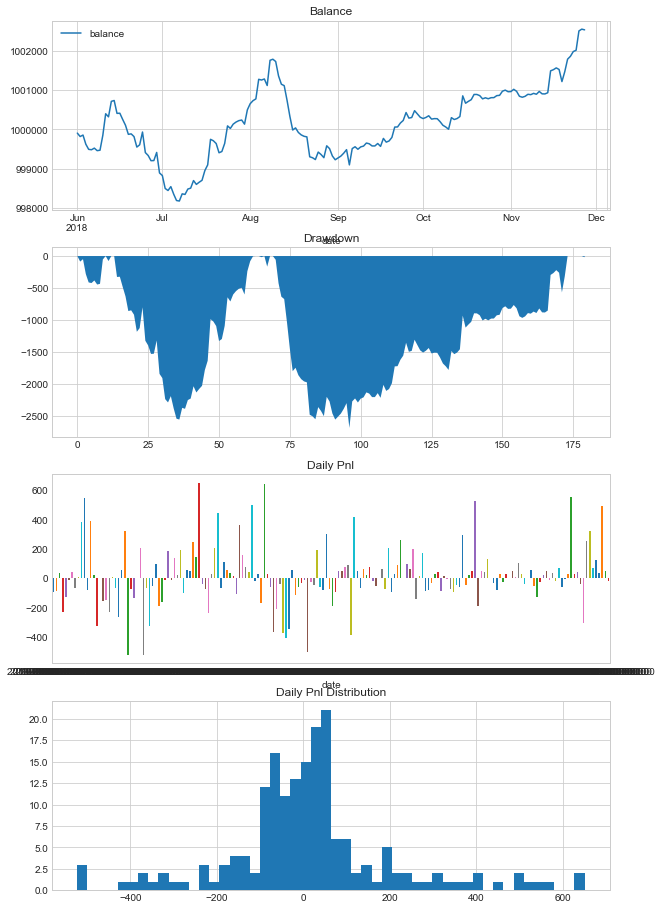

In [9]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-20 22:12:25.268435	计算回测结果
2018-12-20 22:12:25.287386	------------------------------
2018-12-20 22:12:25.287386	第一笔交易：	2018-06-10 21:15:00
2018-12-20 22:12:25.287386	最后一笔交易：	2018-11-27 11:58:00
2018-12-20 22:12:25.287386	总交易次数：	89
2018-12-20 22:12:25.287386	总盈亏：	5.14
2018-12-20 22:12:25.288385	最大回撤: 	-4.48
2018-12-20 22:12:25.288385	平均每笔盈利：	0.06
2018-12-20 22:12:25.288385	平均每笔滑点：	0.0
2018-12-20 22:12:25.288385	平均每笔佣金：	0.01
2018-12-20 22:12:25.288385	胜率		44.94%
2018-12-20 22:12:25.288385	盈利交易平均值	0.42
2018-12-20 22:12:25.288385	亏损交易平均值	-0.24
2018-12-20 22:12:25.288385	盈亏比：	1.76


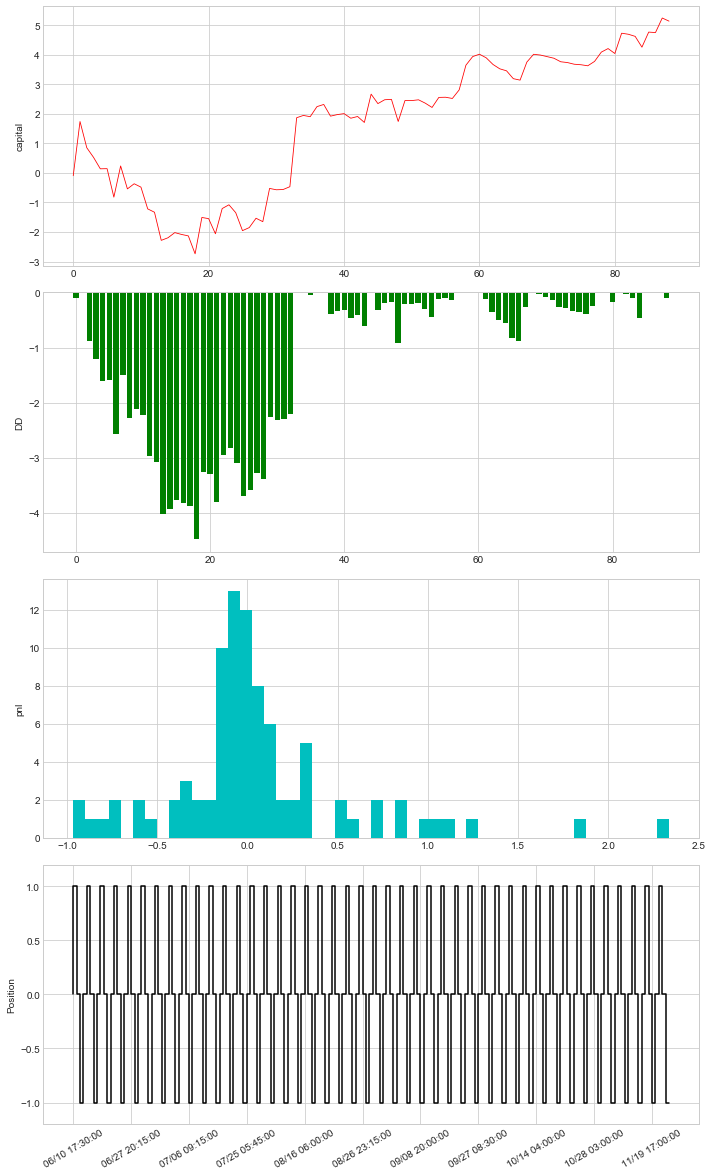

In [5]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2018-12-20 22:12:29.574818	计算按日统计结果
startDate           2018-06-10 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           171
profitDays                           84
lossDays                             87
endBalance                  1.00001e+06
maxDrawdown                    -5.85835
maxDdPercent               -0.000585833
totalNetPnl                     5.14373
dailyNetPnl                   0.0300803
totalCommission                0.578274
dailyCommission              0.00338172
totalSlippage                     0.354
dailySlippage                0.00207018
totalTurnover                   1156.55
dailyTurnover                   6.76344
totalTradeCount                     177
dailyTradeCount                 1.03509
totalReturn                 0.000514373
annualizedReturn            0.000721926
dailyReturn                 3.03244e-06
returnStd                   4.04293e-05
sharpeRatio                     1.16199
dtype: object


In [11]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 15, 35, 3)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 40, 100, 5)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-17 21:55:08.691238	------------------------------
2018-12-17 21:55:08.691238	setting: {'fastPeriod': 15, 'slowPeriod': 40, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0D158>, <__main__.MultiFrameMaStrategy object at 0x0000023449BE3F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0D0D0>, <__main__.MultiFrameMaStrategy object at 0x0000023449BE3F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0DBF8>, <__main__.MultiFrameMaStrategy object at 0x0000023449BE3F60>)
2018-12-17 21:55:08.724147	开始回测
2018-12-17 21:55:08.724147	策略初始化
2018-12-17 21:55:08.725171	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-17 21:55:09.273832	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018

2018-12-17 21:55:49.297537	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:55:49.321475	载入完成，数据量：118890
2018-12-17 21:55:49.321475	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 21:55:49.322471	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 21:55:49.500995	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:55:49.501992	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 21:55:49.518977	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 21:55:51.943419	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:55:51.955387	载入完成，数据量：53630
2018-12-17 21:55:51.961370	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 21:55:51.966357	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:55:51.966357	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 21:57:17.418915	数据回放结束ss: 100%    
2018-12-17 21:57:17.418915	计算按日统计结果
2018-12-17 21:57:17.483622	------------------------------
2018-12-17 21:57:17.483622	setting: {'fastPeriod': 15, 'slowPeriod': 75, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000023444A56268>, <__main__.MultiFrameMaStrategy object at 0x000002344CC2BEB8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000023444A567B8>, <__main__.MultiFrameMaStrategy object at 0x000002344CC2BEB8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000023444A56158>, <__main__.MultiFrameMaStrategy object at 0x000002344CC2BEB8>)
2018-12-17 21:57:17.511547	开始回测
2018-12-17 21:57:17.511547	策略初始化
2018-12-17 21:57:17.512544	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 21:57:58.320337	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:57:58.352264	载入完成，数据量：118890
2018-12-17 21:57:58.352264	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 21:57:58.353242	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 21:57:58.531765	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:57:58.532763	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 21:57:58.554702	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 21:58:00.962394	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:58:00.974361	载入完成，数据量：53630
2018-12-17 21:58:00.979379	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 21:58:00.995961	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:58:00.995961	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 21:59:18.006668	数据回放结束ss: 100%    
2018-12-17 21:59:18.007665	计算按日统计结果
2018-12-17 21:59:18.068503	------------------------------
2018-12-17 21:59:18.068503	setting: {'fastPeriod': 18, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0D950>, <__main__.MultiFrameMaStrategy object at 0x000002344C5B2F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0D0D0>, <__main__.MultiFrameMaStrategy object at 0x000002344C5B2F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D598>, <__main__.MultiFrameMaStrategy object at 0x000002344C5B2F60>)
2018-12-17 21:59:18.092440	开始回测
2018-12-17 21:59:18.092440	策略初始化
2018-12-17 21:59:18.093437	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 21:59:57.729138	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:59:57.754072	载入完成，数据量：118890
2018-12-17 21:59:57.755069	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 21:59:57.756066	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 21:59:57.933323	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 21:59:57.933323	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 21:59:57.951311	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:00:00.297299	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:00:00.308268	载入完成，数据量：53630
2018-12-17 22:00:00.314279	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:00:00.328645	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:00:00.328645	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:01:19.356702	数据回放结束ss: 100%    
2018-12-17 22:01:19.356702	计算按日统计结果
2018-12-17 22:01:19.415543	------------------------------
2018-12-17 22:01:19.415543	setting: {'fastPeriod': 18, 'slowPeriod': 80, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x00000234424A1620>, <__main__.MultiFrameMaStrategy object at 0x00000234488A9F98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000023443EF0950>, <__main__.MultiFrameMaStrategy object at 0x00000234488A9F98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000023443EDDBF8>, <__main__.MultiFrameMaStrategy object at 0x00000234488A9F98>)
2018-12-17 22:01:19.444465	开始回测
2018-12-17 22:01:19.444465	策略初始化
2018-12-17 22:01:19.445464	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:02:02.033049	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:02:02.077932	载入完成，数据量：118890
2018-12-17 22:02:02.077932	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:02:02.078925	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:02:02.437965	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:02:02.439959	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:02:02.468881	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:02:05.161684	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:02:05.173656	载入完成，数据量：53630
2018-12-17 22:02:05.179636	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:02:05.184622	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:02:05.184622	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:03:31.370986	数据回放结束ss: 100%    
2018-12-17 22:03:31.370986	计算按日统计结果
2018-12-17 22:03:31.437806	------------------------------
2018-12-17 22:03:31.437806	setting: {'fastPeriod': 21, 'slowPeriod': 50, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0D0D0>, <__main__.MultiFrameMaStrategy object at 0x0000023448AF5D68>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DD90>, <__main__.MultiFrameMaStrategy object at 0x0000023448AF5D68>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D510>, <__main__.MultiFrameMaStrategy object at 0x0000023448AF5D68>)
2018-12-17 22:03:31.457753	开始回测
2018-12-17 22:03:31.457753	策略初始化
2018-12-17 22:03:31.458750	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:04:25.572214	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:04:25.607125	载入完成，数据量：118890
2018-12-17 22:04:25.608119	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:04:25.609116	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:04:25.950204	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:04:25.951201	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:04:25.978129	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:04:30.881020	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:04:30.895979	载入完成，数据量：53630
2018-12-17 22:04:30.902960	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:04:30.910939	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:04:30.910939	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:05:51.598441	数据回放结束ss: 100%    
2018-12-17 22:05:51.598441	计算按日统计结果
2018-12-17 22:05:51.668222	------------------------------
2018-12-17 22:05:51.668222	setting: {'fastPeriod': 21, 'slowPeriod': 85, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0DD90>, <__main__.MultiFrameMaStrategy object at 0x0000023447ABBE10>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DD08>, <__main__.MultiFrameMaStrategy object at 0x0000023447ABBE10>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0DA60>, <__main__.MultiFrameMaStrategy object at 0x0000023447ABBE10>)
2018-12-17 22:05:51.688168	开始回测
2018-12-17 22:05:51.688168	策略初始化
2018-12-17 22:05:51.689192	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:06:30.096080	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:06:30.122697	载入完成，数据量：118890
2018-12-17 22:06:30.122697	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:06:30.123698	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:06:30.310540	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:06:30.311538	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:06:30.329523	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:06:32.593032	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:06:32.604007	载入完成，数据量：53630
2018-12-17 22:06:32.608986	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:06:32.623179	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:06:32.624151	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:07:46.230444	数据回放结束ss: 100%    
2018-12-17 22:07:46.230444	计算按日统计结果
2018-12-17 22:07:46.289287	------------------------------
2018-12-17 22:07:46.290284	setting: {'fastPeriod': 24, 'slowPeriod': 55, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0D9D8>, <__main__.MultiFrameMaStrategy object at 0x00000234478BEFD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DAE8>, <__main__.MultiFrameMaStrategy object at 0x00000234478BEFD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D730>, <__main__.MultiFrameMaStrategy object at 0x00000234478BEFD0>)
2018-12-17 22:07:46.310230	开始回测
2018-12-17 22:07:46.310230	策略初始化
2018-12-17 22:07:46.311229	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:08:25.191906	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:08:25.216874	载入完成，数据量：118890
2018-12-17 22:08:25.216874	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:08:25.217837	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:08:25.404638	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:08:25.405633	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:08:25.422621	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:08:27.777801	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:08:27.788775	载入完成，数据量：53630
2018-12-17 22:08:27.793761	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:08:27.809029	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:08:27.809994	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:09:41.354859	数据回放结束ss: 100%    
2018-12-17 22:09:41.354859	计算按日统计结果
2018-12-17 22:09:41.413732	------------------------------
2018-12-17 22:09:41.413732	setting: {'fastPeriod': 24, 'slowPeriod': 90, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344E53E510>, <__main__.MultiFrameMaStrategy object at 0x0000023447278F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DEA0>, <__main__.MultiFrameMaStrategy object at 0x0000023447278F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344E53E2F0>, <__main__.MultiFrameMaStrategy object at 0x0000023447278F60>)
2018-12-17 22:09:41.432651	开始回测
2018-12-17 22:09:41.433650	策略初始化
2018-12-17 22:09:41.433650	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:10:19.701440	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:10:19.725378	载入完成，数据量：118890
2018-12-17 22:10:19.725378	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:10:19.726370	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:10:19.903321	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:10:19.904308	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:10:19.921259	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:10:22.296230	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:10:22.307233	载入完成，数据量：53630
2018-12-17 22:10:22.313184	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:10:22.328271	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:10:22.328271	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:11:35.734037	数据回放结束ss: 100%    
2018-12-17 22:11:35.734037	计算按日统计结果
2018-12-17 22:11:35.794899	------------------------------
2018-12-17 22:11:35.794899	setting: {'fastPeriod': 27, 'slowPeriod': 60, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000023444525E18>, <__main__.MultiFrameMaStrategy object at 0x0000023446BC0F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000023444A56598>, <__main__.MultiFrameMaStrategy object at 0x0000023446BC0F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x00000234446A6488>, <__main__.MultiFrameMaStrategy object at 0x0000023446BC0F60>)
2018-12-17 22:11:35.813822	开始回测
2018-12-17 22:11:35.813822	策略初始化
2018-12-17 22:11:35.814851	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:12:14.149895	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:12:14.174341	载入完成，数据量：118890
2018-12-17 22:12:14.174341	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:12:14.175342	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:12:14.351562	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:12:14.352589	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:12:14.370538	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:12:16.724282	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:12:16.735251	载入完成，数据量：53630
2018-12-17 22:12:16.740236	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:12:16.755845	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:12:16.755845	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:13:30.192642	数据回放结束ss: 100%    
2018-12-17 22:13:30.192642	计算按日统计结果
2018-12-17 22:13:30.253239	------------------------------
2018-12-17 22:13:30.253239	setting: {'fastPeriod': 27, 'slowPeriod': 95, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344EB0D950>, <__main__.MultiFrameMaStrategy object at 0x0000023446380FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DC80>, <__main__.MultiFrameMaStrategy object at 0x0000023446380FD0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D0D0>, <__main__.MultiFrameMaStrategy object at 0x0000023446380FD0>)
2018-12-17 22:13:30.272191	开始回测
2018-12-17 22:13:30.272191	策略初始化
2018-12-17 22:13:30.273190	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:14:08.666054	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:14:08.690862	载入完成，数据量：118890
2018-12-17 22:14:08.690862	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:14:08.691862	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:14:08.877611	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:14:08.878637	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:14:08.895561	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:14:11.151657	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:14:11.162664	载入完成，数据量：53630
2018-12-17 22:14:11.167613	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:14:11.182819	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:14:11.182819	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:15:26.870350	数据回放结束ss: 100%    
2018-12-17 22:15:26.870350	计算按日统计结果
2018-12-17 22:15:26.940297	------------------------------
2018-12-17 22:15:26.941295	setting: {'fastPeriod': 30, 'slowPeriod': 65, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344E53E2F0>, <__main__.MultiFrameMaStrategy object at 0x0000023445E38F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000023444A56A60>, <__main__.MultiFrameMaStrategy object at 0x0000023445E38F60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000023444A56158>, <__main__.MultiFrameMaStrategy object at 0x0000023445E38F60>)
2018-12-17 22:15:26.966229	开始回测
2018-12-17 22:15:26.966229	策略初始化
2018-12-17 22:15:26.966229	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:16:08.791528	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:16:08.816494	载入完成，数据量：118890
2018-12-17 22:16:08.816494	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:16:08.817458	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:16:09.100513	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:16:09.101508	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:16:09.117464	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:16:11.384413	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:16:11.395415	载入完成，数据量：53630
2018-12-17 22:16:11.400402	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:16:11.425493	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:16:11.425493	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:17:31.361600	数据回放结束ss: 100%    
2018-12-17 22:17:31.361600	计算按日统计结果
2018-12-17 22:17:31.424402	------------------------------
2018-12-17 22:17:31.425400	setting: {'fastPeriod': 30, 'slowPeriod': 100, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x000002344E53ED08>, <__main__.MultiFrameMaStrategy object at 0x0000023444F3EF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0D158>, <__main__.MultiFrameMaStrategy object at 0x0000023444F3EF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D268>, <__main__.MultiFrameMaStrategy object at 0x0000023444F3EF60>)
2018-12-17 22:17:31.444347	开始回测
2018-12-17 22:17:31.444347	策略初始化
2018-12-17 22:17:31.445376	载入历史数据。数据范围:[20180824 04:00,

2018-12-17 22:18:11.266395	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:18:11.290331	载入完成，数据量：118890
2018-12-17 22:18:11.291327	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:18:11.292355	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:18:11.478462	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:18:11.480490	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:18:11.497447	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:18:13.943993	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:18:13.954964	载入完成，数据量：53630
2018-12-17 22:18:13.960947	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:18:13.965935	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:18:13.965935	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:19:29.628412	数据回放结束ss: 100%    
2018-12-17 22:19:29.628412	计算按日统计结果
2018-12-17 22:19:29.691241	------------------------------
2018-12-17 22:19:29.691241	setting: {'fastPeriod': 33, 'slowPeriod': 70, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x00000234446A6488>, <__main__.MultiFrameMaStrategy object at 0x00000234469FEF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002344EB0DC80>, <__main__.MultiFrameMaStrategy object at 0x00000234469FEF60>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002344EB0D8C8>, <__main__.MultiFrameMaStrategy object at 0x00000234469FEF60>)
2018-12-17 22:19:29.710188	开始回测
2018-12-17 22:19:29.710188	策略初始化
2018-12-17 22:19:29.712183	载入历史数据。数据范围:[20180824 04:00,2

2018-12-17 22:20:09.002694	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:20:09.026670	载入完成，数据量：118890
2018-12-17 22:20:09.027627	当前回放数据:[20180901 12:00,20181123 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180901120000
2018-12-17 22:20:09.028655	载入历史数据。数据范围:[20180831 20:51,20180903 12:01)
2018-12-17 22:20:09.298624	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:20:09.299648	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180901102100 , 20180901120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180901120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180901120000
2018-12-17 22:20:09.318603	载入历史数据。数据范围:[20180725 15:00,20180831 20:50)
2018-12-17 22:20:11.579770	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:20:11.589772	载入完成，数据量：53630
2018-12-17 22:20:11.594760	载入历史数据。数据范围:[20180903 12:01,20180903 13:00)
2018-12-17 22:20:11.611262	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-17 22:20:11.611262	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180828080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831110000 , 20180901114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180901120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180901120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7054.86, 'close': 7059.99, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0), 'volume': 381.507684, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180831111500 , 20180901120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180901120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7067.17, 'high': 7079.0, 'low': 7039.8, 'close': 7054.02, 'date': '20180901', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 9, 1, 12, 0

2018-12-17 22:21:30.875309	数据回放结束ss: 100%    
2018-12-17 22:21:30.875309	计算按日统计结果
2018-12-17 22:21:30.920161	------------------------------
2018-12-17 22:21:30.920161	优化结果：
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 33, 'slowPeriod': 55, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.279196264792196
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 15, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.021391008714355
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 18, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.999882945047004
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 21, 'slowPeriod': 55, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.972520410574871
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 21, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.940883436255489
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 24, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}"]，目标：3.906490113031809
2018-12-17 22:21:30.920161	参数：["{'fastPeriod': 30, 'slowPeriod': 

### 打印最优结果排序的DataFrame

In [12]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                    0         1  \
0   [{'fastPeriod': 33, 'slowPeriod': 55, 'symbolL...  4.279196   
1   [{'fastPeriod': 15, 'slowPeriod': 45, 'symbolL...  4.021391   
2   [{'fastPeriod': 18, 'slowPeriod': 45, 'symbolL...  3.999883   
3   [{'fastPeriod': 21, 'slowPeriod': 55, 'symbolL...  3.972520   
4   [{'fastPeriod': 21, 'slowPeriod': 45, 'symbolL...  3.940883   
5   [{'fastPeriod': 24, 'slowPeriod': 45, 'symbolL...  3.906490   
6   [{'fastPeriod': 30, 'slowPeriod': 45, 'symbolL...  3.888710   
7   [{'fastPeriod': 15, 'slowPeriod': 40, 'symbolL...  3.830481   
8   [{'fastPeriod': 27, 'slowPeriod': 45, 'symbolL...  3.763048   
9   [{'fastPeriod': 18, 'slowPeriod': 50, 'symbolL...  3.748175   
10  [{'fastPeriod': 21, 'slowPeriod': 50, 'symbolL...  3.730449   
11  [{'fastPeriod': 21, 'slowPeriod': 60, 'symbolL...  3.729467   
12  [{'fastPeriod': 18, 'slowPeriod': 40, 'symbolL...  3.719975   
13  [{'fastPeriod': 24, 'slowPeriod': 55, 'symbolL...  3.71331

In [13]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))

------------------------------
参数：["{'fastPeriod': 33, 'slowPeriod': 55, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.279196264792196
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：48
lossDays：35
endBalance：1002659.68416
maxDrawdown：-867.3808599999174
maxDdPercent：-0.08698991800681256
totalNetPnl：2659.684159999991
dailyNetPnl：31.66290666666656
totalCommission：251.84784000000002
dailyCommission：2.998188571428572
totalSlippage：0.158
dailySlippage：0.001880952380952381
totalTurnover：503695.68000000005
dailyTurnover：5996.377142857144
totalTradeCount：79
dailyTradeCount：0.9404761904761905
totalReturn：0.2659684159999953
annualizedReturn：0.7599097599999866
dailyReturn：0.00982127162024462
returnStd：0.03555585588513231
sharpeRatio：4.279196264792196
------------------------------
参数：["{'fastPeriod': 15, 'slowPeriod': 45, 'symbolList': ['BTCUSDT:binance']}"]，目标：4.021391008714355
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profit

lossDays：39
endBalance：1002301.30611
maxDrawdown：-634.5770199999679
maxDdPercent：-0.06338966683663956
totalNetPnl：2301.306110000001
dailyNetPnl：27.39650130952382
totalCommission：165.14189
dailyCommission：1.965974880952381
totalSlippage：0.10200000000000001
dailySlippage：0.0012142857142857144
totalTurnover：330283.78
dailyTurnover：3931.9497619047625
totalTradeCount：51
dailyTradeCount：0.6071428571428571
totalReturn：0.2301306109999901
annualizedReturn：0.6575160314285431
dailyReturn：0.00260677036746635
returnStd：0.014505614792066713
sharpeRatio：2.78401939257501
------------------------------
参数：["{'fastPeriod': 27, 'slowPeriod': 75, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.781853241895962
统计数据：
startDate：2018-09-01 00:00:00
endDate：2018-11-23 00:00:00
totalDays：84
profitDays：45
lossDays：37
endBalance：1002209.27298
maxDrawdown：-452.1594299999997
maxDdPercent：-0.04517530205008212
totalNetPnl：2209.2729799999984
dailyNetPnl：26.30086880952379
totalCommission：190.53902
dailyCommission：2.268321666